In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
from loss import CE, Align, Reconstruct
from torch.optim.lr_scheduler import LambdaLR
# from classification import fit_lr, get_rep_with_label
import os
import warnings

warnings.filterwarnings('ignore')
# from args import args, Test_data, Train_data_all, Train_data
from dataset import Dataset
from model.TimeMAE import TimeMAE
# from process import Trainer
import torch.utils.data as Data
import argparse

from datautils import load_UCR, load_txt_regress, load_txt_valid
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# data = pd.read_csv('data/EFSCV/EFSCV_TRAIN.txt', sep='\t')




In [2]:
labels =np.load('exp/mono_full_EFSCV2/test/preds/label_epoch_038.npy')
preds = np.load('exp/mono_full_EFSCV2/test/preds/pred_epoch_038.npy')


In [ ]:
filename = 'exp/mono_full_EFSCV2/test'
with open(filename + '/args.json', 'r') as file:
    args = json.load(file)

args = argparse.Namespace(**args)

Train_data, Valid_data, Test_data = load_txt_regress(folder=args.UCR_folder)
train_dataset = Dataset(device=args.device, mode='pretrain', data=Train_data, wave_len=args.wave_length, analysis=1)
train_loader = Data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

# valid_dataset = Dataset(device=args.device, mode='valid', data=Valid_data, wave_len=args.wave_length, analysis=1)
# valid_loader = Data.DataLoader(valid_dataset, batch_size=args.train_batch_size)

test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length, analysis=1)
test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)
args.data_shape = test_dataset.shape()
# args.num_targets = 1
model = TimeMAE(args)
state_dict = torch.load(filename + '/finetune_model_checkpoint_030.pkl', map_location='cpu')
model_state_dict = model.state_dict()
for name, param in state_dict.items():
    if name in model_state_dict:
        if param.shape == model_state_dict[name].shape:
            model_state_dict[name] = param
        else:
            print(f"Skipping {name} due to shape mismatch: {param.shape} vs {model_state_dict[name].shape}")
model.load_state_dict(model_state_dict)

In [ ]:
filename = 'exp/mono_full_EFSCV2/test'
with open(filename + '/args.json', 'r') as file:
    args = json.load(file)

args = argparse.Namespace(**args)

Train_data, Valid_data, Test_data = load_txt_valid(folder=args.UCR_folder)
train_dataset = Dataset(device=args.device, mode='pretrain', data=Train_data, wave_len=args.wave_length, analysis=1)
train_loader = Data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

valid_dataset = Dataset(device=args.device, mode='valid', data=Valid_data, wave_len=args.wave_length, analysis=1)
valid_loader = Data.DataLoader(valid_dataset, batch_size=args.train_batch_size)

test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length, analysis=1)
test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)

args.data_shape = valid_dataset.shape()
# args.num_targets = 1
model = TimeMAE(args)
state_dict = torch.load(filename + '/finetune_model_checkpoint_030.pkl', map_location='cpu')
model_state_dict = model.state_dict()
for name, param in state_dict.items():
    if name in model_state_dict:
        if param.shape == model_state_dict[name].shape:
            model_state_dict[name] = param
        else:
            print(f"Skipping {name} due to shape mismatch: {param.shape} vs {model_state_dict[name].shape}")
model.load_state_dict(model_state_dict)



loading_data


FileNotFoundError: [Errno 2] No such file or directory: 'data/mono_full_EFSCV/mono_full_EFSCV_VALID.txt'

In [ ]:
def get_tsne(loader, model):
    """
    Run TSNE and make dataframe
    """

    reps = []
    labels = []
    e_names = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            seqs, label, e_name = batch
            label = label.numpy()
            e_name = list(e_name)
            
            rep_batch = model(seqs)
            for i in range(len(rep_batch)):
                reps.append(rep_batch[i].numpy())
                labels.append(label[i])
                e_names.append(e_name[i])
    reps= np.array(reps)
    tsne = TSNE(n_components=2, random_state=4399)
    rep_new = tsne.fit_transform(reps)

    NeurTM= []
    labels = np.array(labels)
    for i in range(labels.shape[0]):
        if labels[i][0] > 0:
            NeurTM.append('D')
        elif labels[i][1] > 0:
            NeurTM.append('S')
        else:
            NeurTM.append('C')


    df = pd.DataFrame({
    'x': rep_new[:,0],
    'y': rep_new[:,1],
    'E_name': e_names,
    'NeurTM': NeurTM
    })
    
    return df

In [ ]:
df_test = get_tsne(test_loader, model)
# df_train = get_tsne(train_loader, model)
# df_valid = get_tsne(valid_loader, model)

100%|██████████| 221/221 [07:15<00:00,  1.97s/it]


In [5]:
np.unique(df_valid['E_name'])

array(["['Carbon Fiber #16 after epoxy']", "['Carbon Fiber #17']"],
      dtype=object)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, r2_score

# from classification import get_rep_with_label
def get_rep_with_label(model, dataloader):
    reps = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            seq, label, _ = batch
            seq = seq.to(args.device)
            labels += label.cpu().numpy().tolist()
            rep = model(seq)
            reps += rep.cpu().numpy().tolist()
    return reps, labels

model.eval()
train_rep, train_label = get_rep_with_label(model, train_loader)  
valid_rep, true_vals = get_rep_with_label(model, valid_loader)
# test_rep, true_vals = get_rep_with_label(model, test_loader)
      
reg = LinearRegression().fit(train_rep, train_label)
predicted_vals = reg.predict(valid_rep)
# predicted_vals = reg.predict(test_rep)
# mse = mean_squared_error(true_vals, predicted_vals)
residuals = np.array(true_vals) - np.array(predicted_vals)

# Optional: dopamine = column 0, serotonin = column 1
dopamine_pred, serotonin_pred = predicted_vals[:, 0], predicted_vals[:, 1]
dopamine_true, serotonin_true = np.array(true_vals)[:, 0], np.array(true_vals)[:,1]

residuals_dopamine = dopamine_true - dopamine_pred
residuals_serotonin = serotonin_true - serotonin_pred

  0%|          | 0/2906 [00:00<?, ?it/s]

100%|██████████| 221/221 [02:31<00:00,  1.46it/s]


In [15]:
save_path = 'exp/EFSCV_full/'
epoch_dir = os.path.join(save_path, "preds")
os.makedirs(epoch_dir, exist_ok=True)
np.save(os.path.join(epoch_dir, f"pred_epoch_040.npy"), np.array(predicted_vals))
np.save(os.path.join(epoch_dir, f"label_epoch_040.npy"), np.array(true_vals)) 

In [7]:
print(r2_score(dopamine_true, dopamine_pred))

print(r2_score(serotonin_true, serotonin_pred))

r2_score(true_vals, predicted_vals)


0.4585033708679468
-0.34215041147547254


0.05817647969593642

In [8]:
df_valid = pd.DataFrame({
    'x': df_valid['x'],
    'y': df_valid['y'],
    'dopamine_pred': dopamine_pred,
    'serotonin_pred': serotonin_pred,
    'dopamine_true': dopamine_true, 
    'serotonin_true': serotonin_true,
    'residuals_dopamine': residuals_dopamine,
    'residuals_serotonin': residuals_serotonin,
    'E_name': df_valid['E_name'],
    'NeurTM': df_valid['NeurTM']
})

In [6]:
df_test = pd.DataFrame({
    'x': df_test['x'],
    'y': df_test['y'],
    'dopamine_pred': dopamine_pred,
    'serotonin_pred': serotonin_pred,
    'dopamine_true': dopamine_true, 
    'serotonin_true': serotonin_true,
    'residuals_dopamine': residuals_dopamine,
    'residuals_serotonin': residuals_serotonin,
    'E_name': df_test['E_name'],
    'NeurTM': df_test['NeurTM']
})

In [3]:
reps = []
labels = []
e_names = []
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader)):
        seqs, label, e_name = batch
        label = label.numpy()
        e_name = list(e_name)
        
        rep_batch = model(seqs)
        for i in range(len(rep_batch)):
            reps.append(rep_batch[i].numpy())
            labels.append(label[i])
            e_names.append(e_name[i])
reps= np.array(reps)
tsne = TSNE(n_components=2, random_state=4399)
rep_new = tsne.fit_transform(reps)

100%|██████████| 319/319 [00:12<00:00, 26.14it/s]


In [32]:
NeurTM= []
labels = np.array(labels)
for i in range(labels.shape[0]):
    if labels[i][0] > 0:
        NeurTM.append('D')
    elif labels[i][1] > 0:
        NeurTM.append('S')
    else:
        NeurTM.append('C')

# Map string labels to numbers
label_to_int = {label: idx for idx, label in enumerate(set(NeurTM))}
numeric_labels = [label_to_int[label] for label in NeurTM]

In [22]:

e_name_to_int = {label: idx for idx, label in enumerate(set(e_names))}
numeric_enames = [e_name_to_int[label] for label in e_names]

In [5]:
colors = sns.husl_palette(26)
# colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000080', '#b8b8ff', '#a9a9a9', '#d3d3d3', '#000000', '#ffffff', '#999999', '#cccccc']
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.969775554536923, 0.45572393057172517, 0.3816974986244644),
 (0.9218528551477547, 0.500345433264, 0.19606247053399534),
 (0.8280021119246898, 0.5541101460994343, 0.19519034373355515),
 (0.756593795426372, 0.58660455674609, 0.19460548454202936),
 (0.6930187589536538, 0.6108108694342007, 0.19414054789385224),
 (0.6280838378584804, 0.6317149736053096, 0.19371846323785552),
 (0.5513905416466857, 0.6521744451123571, 0.19328652546337113),
 (0.44127702936426016, 0.6747986506725627, 0.19278677787286805),
 (0.1922767820051321, 0.7030180462018473, 0.19746728712660622),
 (0.19925855442314272, 0.6935861010390585, 0.4349484671340832),
 (0.2037889733341985, 0.6871740568706872, 0.5304740275460067),
 (0.20730980534421067, 0.6820252887361699, 0.5931178995944008),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.213603436221035, 0.6724447149771248, 0.6900417229996091),
 (0.2171884226681146, 0.6667620195412343, 0.7393249417449974),
 (0.2218708221705632, 0.6590814541823624, 0.7990680761766646),
 (0.22924357895524167, 0.6463621902263882, 0.8851808844077328),
 (0.38670894369284947, 0.6148978276981065, 0.9585912355668605),
 (0.5733059471633944, 0.5724693464895717, 0.9583735366839873),
 (0.7049741506310939, 0.5248938690186019, 0.9581527270311664),
 (0.8245107303669379, 0.462619678699226, 0.9578997078411405),
 (0.9538763597142671, 0.3594595647605631, 0.95756585161213),
 (0.9611655105740858, 0.3882127838479558, 0.8413668527977347),
 (0.9637107389395935, 0.4095260281088575, 0.7436447221919831),
 (0.9657673298614505, 0.4258473366660958, 0.6499716417031115)]

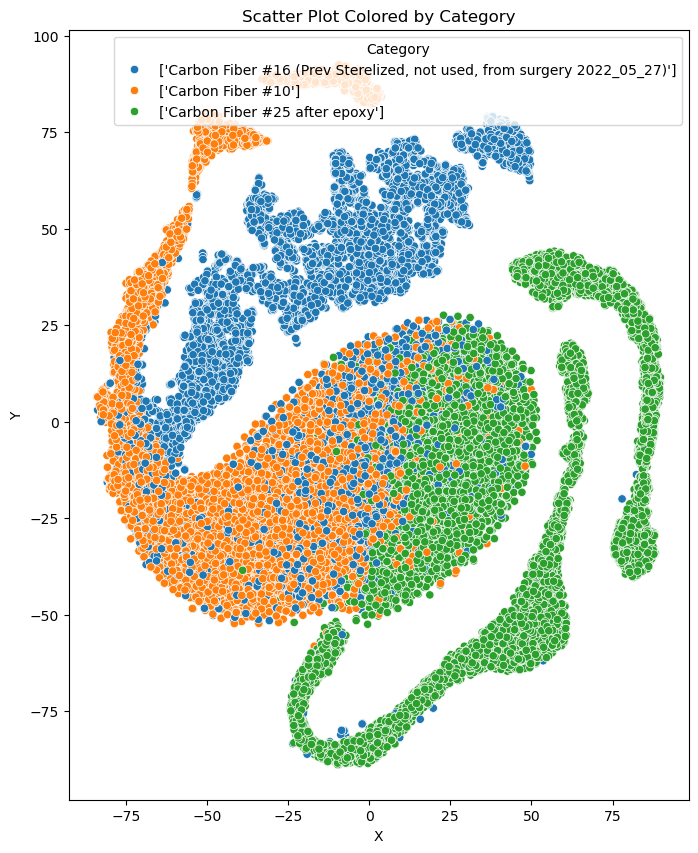

In [ ]:
# Use seaborn to create scatter plot with automatic color mapping
plt.figure(figsize=(8, 10))
sns.scatterplot(data=df_test, x='x', y='y', hue='E_name')

plt.title('Scatter Plot Colored by Category')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(title='Category')
plt.show()

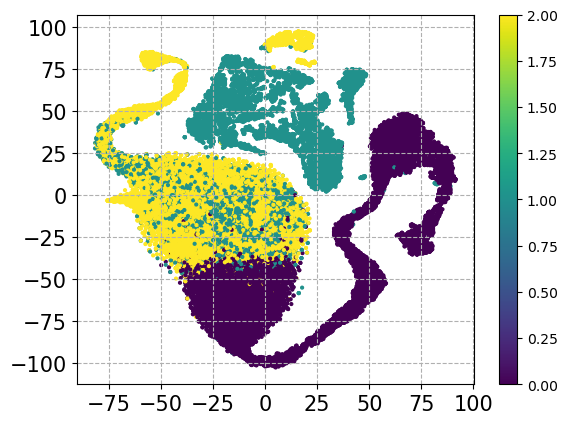

In [46]:
plt.scatter(rep_new[:, 0], rep_new[:, 1], c=numeric_enames, s=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(ls='--')
# plt.savefig('exp/smallFSCV/random.svg', format='svg')
plt.colorbar()
plt.show()

#check if overlap is low concentration

In [57]:
np.array(train_label)

array([[1250.        ,    0.        ],
       [   0.        ,  218.75      ],
       [   0.        ,    3.56445312],
       ...,
       [   0.        , 1000.        ],
       [   0.        ,   15.625     ],
       [   0.        ,   15.625     ]])

In [10]:
np.unique(df_test['E_name'])

array(["['Carbon Fiber # 25']", "['Carbon Fiber #13']",
       "['Carbon Fiber #15']",
       "['Carbon Fiber #16 (Prev Sterelized, not used, from surgery 2022_05_27)']",
       "['Carbon Fiber #18 after epoxy']", "['Carbon Fiber #18']",
       "['Carbon Fiber #19 after epoxy']", "['Carbon Fiber #19']",
       "['Carbon Fiber #20 (short)']", "['Carbon Fiber #22 (short)']",
       "['Carbon Fiber #23']", "['Carbon Fiber #24']",
       "['Carbon Fiber #28 after epoxy']", "['Carbon Fiber #28']",
       "['Carbon Fiber #29']", "['Carbon Fiber #30']",
       "['Carbon Fiber #33']", "['Carbon Fiber #41 (Mia)']",
       "['Carbon Fiber #6']", "['Carbon Fiber (prev sterilized)']", '[]'],
      dtype=object)

In [ ]:
df_test['dopamine']

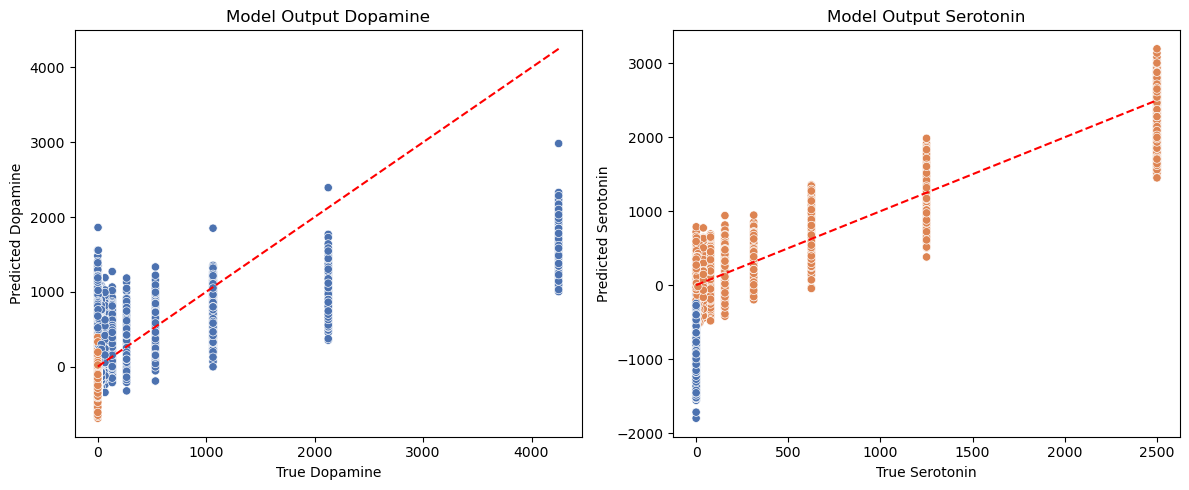

In [12]:
# Use seaborn to create scatter plot with automatic color mapping
save_dir = os.path.split(filename)[0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_valid, x='dopamine_true', y='dopamine_pred', hue='E_name', palette='deep')
plt.plot([min(dopamine_true), max(dopamine_true)], [min(dopamine_true), max(dopamine_true)], 'r--')
# plt.legend(loc= 'upper left', fontsize='8')  # ← customize here
plt.legend([],[], frameon=False)
plt.xlabel("True Dopamine")
plt.ylabel("Predicted Dopamine")
plt.title('Model Output Dopamine')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_valid, x='serotonin_true', y='serotonin_pred', hue='E_name', palette='deep', legend = False)
plt.plot([min(serotonin_true), max(serotonin_true)], [min(serotonin_true), max(serotonin_true)], 'r--')
plt.xlabel("True Serotonin")
plt.ylabel("Predicted Serotonin")
plt.title('Model Output Serotonin')

plt.tight_layout()
# plt.savefig(save_dir + "/Pred_vs_True_Valid.png")
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

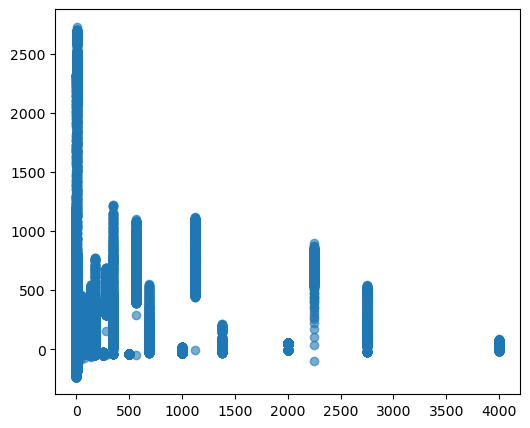

In [5]:
# 1. Predicted vs. True Values Plot
%matplotlib inline
plt.figure(figsize=(6, 5))
plt.scatter(labels, preds, alpha=0.6)
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--')
plt.xlabel('True Dopamine')
plt.ylabel('Predicted Dopamine')
plt.title('Predicted vs. True Values')
plt.grid(True)
plt.tight_layout()
plt.show()




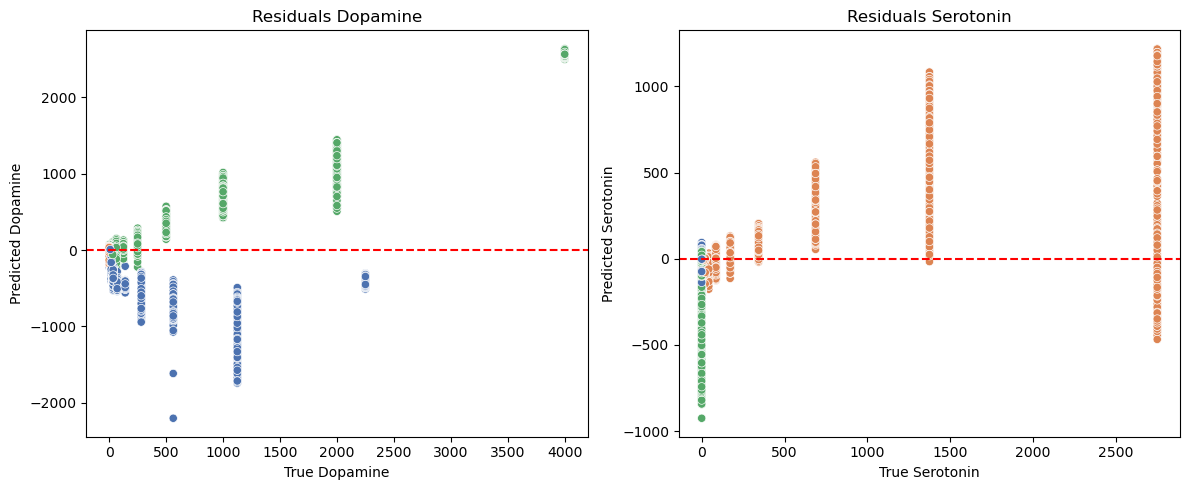

In [9]:
# 2. Residual Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_test, x='dopamine_true', y='residuals_dopamine', hue='E_name', palette='deep')

plt.axhline(y=0, color='red', linestyle='--')
# plt.legend(loc= 'upper left', fontsize='8')  # ← customize here
plt.legend([],[], frameon=False)

plt.xlabel("True Dopamine")
plt.ylabel("Predicted Dopamine")
plt.title('Residuals Dopamine')
# plt.title(f"Dopamine R2: {r2_score(dopamine_true, dopamine_pred):.2f}")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_test, x='serotonin_true', y='residuals_serotonin', hue='E_name', palette='deep', legend=False)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("True Serotonin")
plt.ylabel("Predicted Serotonin")
plt.title('Residuals Serotonin')

# plt.title(f"Serotonin R2: {r2_score(serotonin_true, serotonin_pred):.2f}")

plt.tight_layout()
plt.savefig(save_dir + "/Residuals.png")
plt.show()

# plt.figure(figsize=(6, 5))
# plt.scatter(true_vals, residuals, alpha=0.6)
# plt.axhline(y=0, color='red', linestyle='--')
# plt.xlabel('True Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.grid(True)
# plt.tight_layout()
# plt.show()



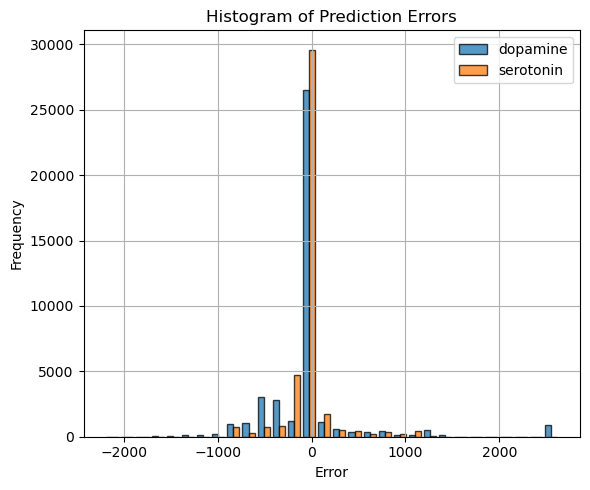

In [10]:
# 3. Residuals Histogram
plt.figure(figsize=(6, 5))
plt.hist(residuals, bins=30, label = ['dopamine', 'serotonin'],alpha=0.75, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(save_dir + "/Histogram.png")
plt.show()


In [27]:
import torch
filename = 'exp/DVFSCV_AllData/test'
with open(filename + '/args.json', 'r') as file:
    args = json.load(file)

args = argparse.Namespace(**args)

# Train_data_all, Train_data, Test_data = load_txt_regress(folder=args.UCR_folder)
# train_dataset = Dataset(device=args.device, mode='pretrain', data=Train_data_all, wave_len=args.wave_length)
# train_loader = Data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)
# test_dataset = Dataset(device=args.device, mode='test', data=Test_data, wave_len=args.wave_length)
# test_loader = Data.DataLoader(test_dataset, batch_size=args.test_batch_size)
args.data_shape = test_dataset.shape()
model = TimeMAE(args)

state_dict = torch.load('exp/DVFSCV_AllData/old/finetune_model_checkpoint025.pkl', map_location='cpu')
model_state_dict = model.load_state_dict(state_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model.load_state_dict(state_dict)

checkpoint = {
    'epoch': 25,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # must come *after* model load
    'step': 0,
    'best_metric': -1e9
}

torch.save(checkpoint, filename + '/finetune_checkpoint_epoch025.pkl')

21


In [67]:
import pandas as pd
path = ('data/Regress_DVSFSCV/Regress_DVSFSCV_TRAIN.txt')
pd.read_csv(path, sep='\t')

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att159,att160,att161,att162,att163,att164,att165,att166,Dopamine,5HT
0,140.537810,335.23123,150.137770,50.005234,40.557860,33.207485,30.513220,29.541016,27.478899,26.729040,...,4.002162,4.503523,3.125872,4.346575,3.274100,1.172747,0.418527,1.007080,0.0000,562.500000
1,111.389160,221.30913,76.947900,27.836391,27.736120,23.297990,21.881104,20.843506,18.986294,18.436977,...,-5.863735,-4.071917,-2.676828,-1.172747,0.235421,0.078474,0.061035,0.908746,0.0000,406.250000
2,99.317280,204.77731,77.366425,28.403147,27.709960,23.175920,22.046770,21.200998,18.864223,18.441338,...,-5.166190,-3.976005,-3.165109,-0.732422,-0.061035,-0.170027,0.074114,0.885010,625.0000,0.000000
3,99.094940,186.44496,57.163784,17.953056,19.134521,15.973773,15.428816,14.556885,13.196673,13.201033,...,-1.185826,-0.579834,-0.898089,0.893729,0.797817,-0.544957,-0.497001,0.224280,0.0000,250.000000
4,96.779960,180.11475,51.169262,14.190674,16.052246,13.458252,12.887137,12.394497,11.073522,11.884418,...,1.565116,1.338414,1.517160,1.874651,1.508440,0.405448,0.143869,0.108507,0.0000,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,75.853620,148.22388,55.764336,20.996094,19.387383,16.322544,15.093122,14.426095,13.331822,13.026647,...,-0.518799,-0.405448,-0.043597,0.902448,1.255580,0.047956,-0.043597,0.269330,39.0625,0.000000
39996,123.282300,259.80923,99.618095,37.275043,35.587856,30.238562,27.522497,26.428223,24.121965,22.827148,...,-0.213623,0.457764,0.026158,1.194545,1.595633,-0.488281,-0.361851,0.552223,0.0000,2.294922
39997,95.380516,175.14911,48.409600,13.301305,15.533447,12.307303,11.932373,11.784145,11.247908,10.894775,...,3.199986,2.611433,2.864293,3.435407,2.803258,1.055036,0.762939,1.173716,0.0000,2000.000000
39998,124.298096,262.00214,102.927070,41.255405,39.005825,33.203125,30.434746,28.926306,26.066372,25.360107,...,-5.026681,-4.002162,-3.544399,-1.373291,-0.475202,-1.408168,-1.273019,-0.048441,0.0000,0.573730


In [43]:
reps = []
labels = []
e_names = []
with torch.no_grad():
    for idx, batch in enumerate(tqdm(train_loader)):
        seqs, label, e_name = batch
        label = label.numpy()
        e_name = list(e_name)
        
        rep_batch = model(seqs)
        for i in range(len(rep_batch)):
            reps.append(rep_batch[i].numpy())
            labels.append(label[i])
            e_names.append(e_name[i])

100%|██████████| 2906/2906 [02:14<00:00, 21.59it/s]


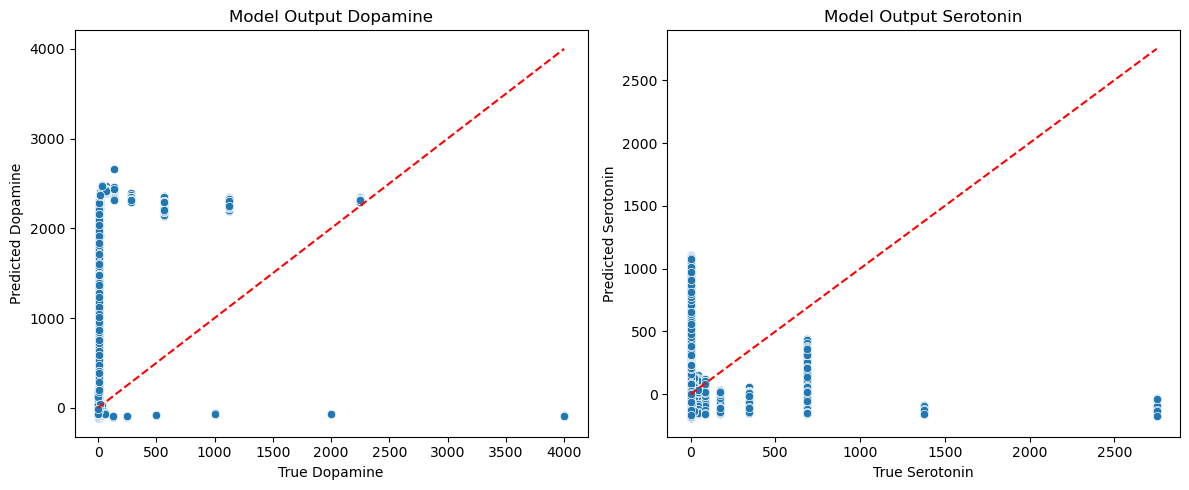

In [8]:
true_vals =np.load('exp/mono_full_EFSCV2/test/preds/label_epoch_030.npy')
predicted_vals = np.load('exp/mono_full_EFSCV2/test/preds/pred_epoch_030.npy')

dopamine_pred, serotonin_pred = predicted_vals[:, 0], predicted_vals[:, 1]
dopamine_true, serotonin_true = np.array(true_vals)[:, 0], np.array(true_vals)[:,1]

residuals_dopamine = dopamine_true - dopamine_pred
residuals_serotonin = serotonin_true - serotonin_pred

# Use seaborn to create scatter plot with automatic color mapping
# save_dir = os.path.split(filename)[0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=dopamine_true, y=dopamine_pred)
plt.plot([min(dopamine_true), max(dopamine_true)], [min(dopamine_true), max(dopamine_true)], 'r--')
# plt.legend(loc= 'upper left', fontsize='8')  # ← customize here
plt.legend([],[], frameon=False)
plt.xlabel("True Dopamine")
plt.ylabel("Predicted Dopamine")
plt.title('Model Output Dopamine')

plt.subplot(1, 2, 2)
sns.scatterplot(x=serotonin_true, y=serotonin_pred)
plt.plot([min(serotonin_true), max(serotonin_true)], [min(serotonin_true), max(serotonin_true)], 'r--')
plt.xlabel("True Serotonin")
plt.ylabel("Predicted Serotonin")
plt.title('Model Output Serotonin')

plt.tight_layout()
# plt.savefig(save_dir + "/Pred_vs_True_Valid.png")
plt.show()

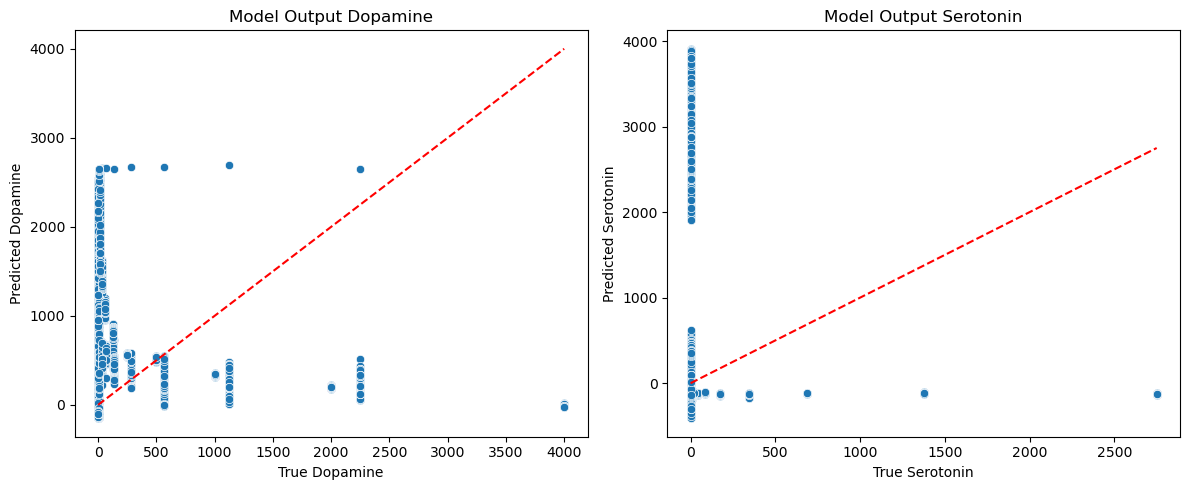

In [6]:
# Use seaborn to create scatter plot with automatic color mapping
# save_dir = os.path.split(filename)[0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=dopamine_true, y=dopamine_pred)
plt.plot([min(dopamine_true), max(dopamine_true)], [min(dopamine_true), max(dopamine_true)], 'r--')
# plt.legend(loc= 'upper left', fontsize='8')  # ← customize here
plt.legend([],[], frameon=False)
plt.xlabel("True Dopamine")
plt.ylabel("Predicted Dopamine")
plt.title('Model Output Dopamine')

plt.subplot(1, 2, 2)
sns.scatterplot(x=serotonin_true, y=serotonin_pred)
plt.plot([min(serotonin_true), max(serotonin_true)], [min(serotonin_true), max(serotonin_true)], 'r--')
plt.xlabel("True Serotonin")
plt.ylabel("Predicted Serotonin")
plt.title('Model Output Serotonin')

plt.tight_layout()
# plt.savefig(save_dir + "/Pred_vs_True_Valid.png")
plt.show()

In [ ]:
# make_plots.py
import os, glob, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(context="talk", style="whitegrid")

SAVE_PATH = "exp/no_diff/test"   # <-- adjust as needed
PRED_DIR = os.path.join(SAVE_PATH, "preds")
os.makedirs(os.path.join(SAVE_PATH, "figs"), exist_ok=True)

def load_epoch_arrays(epoch):
    y_hat = np.load(os.path.join(PRED_DIR, f"pred_epoch_{epoch:03d}.npy"))
    y = np.load(os.path.join(PRED_DIR, f"label_epoch_{epoch:03d}.npy"))
    return y_hat, y

# Choose the latest epoch with files present
epochs = sorted(int(os.path.basename(f).split("_")[-1].split(".")[0])
                for f in glob.glob(os.path.join(PRED_DIR, "pred_epoch_*.npy")))
assert epochs, "No saved prediction files found. Add the np.save code in eval_model()."
E = epochs[-1]
y_hat, y = load_epoch_arrays(E)
y_hat = np.array(y_hat); y = np.array(y)

is_multitarget = (y.ndim == 2 and y.shape[1] > 1)

def parity_plot(y, y_hat, title, ax):
    lims = [min(y.min(), y_hat.min()), max(y.max(), y_hat.max())]
    ax.scatter(y, y_hat, s=10, alpha=0.5)
    ax.plot(lims, lims, 'r--', lw=2, label="Ideal")
    ax.set_xlabel("True"); ax.set_ylabel("Predicted"); ax.set_title(title)
    ax.set_xlim(lims); ax.set_ylim(lims); ax.legend()

def residual_plots(y, y_hat, title_prefix):
    res = y_hat - y
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    # Residual vs Prediction
    axes[0].scatter(y_hat, res, s=8, alpha=0.5)
    axes[0].axhline(0, color='r', ls='--'); axes[0].set_title(f"{title_prefix}: Residual vs Pred")
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Residual")
    # Residual distribution
    sns.histplot(res, kde=True, ax=axes[1]); axes[1].set_title(f"{title_prefix}: Residual dist")
    # Q-Q plot
    from scipy import stats
    stats.probplot(res.flatten(), dist="norm", plot=axes[2])
    axes[2].set_title(f"{title_prefix}: Q-Q")
    fig.tight_layout()
    fig.savefig(os.path.join(SAVE_PATH, "figs", f"{title_prefix}_residuals_epoch_{E:03d}.png"), dpi=150)

if is_multitarget:
    names = ["dopamine", "serotonin"][:y.shape[1]]
    fig, axes = plt.subplots(1, y.shape[1], figsize=(6*y.shape[1],6))
    for i in range(y.shape[1]):
        parity_plot(y[:, i], y_hat[:, i], f"Parity ({names[i]}) — epoch {E}", axes[i])
        residual_plots(y[:, i], y_hat[:, i], f"{names[i]}")
    fig.tight_layout()
    fig.savefig(os.path.join(SAVE_PATH, "figs", f"parity_multitarget_epoch_{E:03d}.png"), dpi=150)

    # Cross-target residual correlation
    res = y_hat - y
    plt.figure(figsize=(6,6))
    plt.scatter(res[:,0], res[:,1], s=10, alpha=0.5)
    plt.axhline(0, color='k', ls=':'); plt.axvline(0, color='k', ls=':')
    plt.xlabel("Residual (dopamine)"); plt.ylabel("Residual (serotonin)")
    plt.title(f"Residual correlation — epoch {E}")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_PATH, "figs", f"residual_correlation_epoch_{E:03d}.png"), dpi=150)
else:
    # Single target
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    parity_plot(y, y_hat, f"Parity — epoch {E}", ax)
    fig.tight_layout()
    fig.savefig(os.path.join(SAVE_PATH, "figs", f"parity_epoch_{E:03d}.png"), dpi=150)
    residual_plots(y, y_hat, "single_target")

# Optional: sample a few sequences and overlay true vs pred if shape permits
# (Requires you to save per-timestep preds/labels; current code aggregates over batches)
print(f"Saved figures to {os.path.join(SAVE_PATH, 'figs')}")


["['Carbon Fiber #28']",
 "['Carbon Fiber (prev sterilized)']",
 '[]',
 "['Carbon Fiber #28']",
 "['Carbon Fiber #23']",
 "['Carbon Fiber #15']",
 "['Carbon Fiber #28']",
 '[]',
 "['Carbon Fiber # 25']",
 "['Carbon Fiber (prev sterilized)']",
 "['Carbon Fiber #18']",
 "['Carbon Fiber #19 after epoxy']",
 "['Carbon Fiber #18']",
 "['Carbon Fiber (prev sterilized)']",
 "['Carbon Fiber #29']",
 "['Carbon Fiber (prev sterilized)']",
 "['Carbon Fiber #15']",
 "['Carbon Fiber #19 after epoxy']",
 "['Carbon Fiber #29']",
 "['Carbon Fiber #19']",
 "['Carbon Fiber #18']",
 "['Carbon Fiber #20 (short)']",
 "['Carbon Fiber #6']",
 "['Carbon Fiber #16 (Prev Sterelized, not used, from surgery 2022_05_27)']",
 "['Carbon Fiber #22 (short)']",
 "['Carbon Fiber #28']",
 "['Carbon Fiber #28']",
 '[]',
 "['Carbon Fiber (prev sterilized)']",
 '[]',
 "['Carbon Fiber #29']",
 "['Carbon Fiber #18 after epoxy']",
 "['Carbon Fiber #33']",
 "['Carbon Fiber #30']",
 "['Carbon Fiber #16 (Prev Sterelized, not used

In [2]:
path = ('data/mono_full_EFSCV/mono_full_EFSCV_TEST.txt')
data = pd.read_csv(path, sep='\t')

In [3]:
data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att2494,att2495,att2496,att2497,att2498,att2499,att2500,electrode,Dopamine,5HT
0,-6.713867,-6.713867,-6.713867,-6.713867,-6.713867,-6.774902,-6.713867,-6.652832,-6.286621,-5.676270,...,-774.41406,-774.16990,-774.23096,-774.23096,-774.10890,-774.04785,-774.10890,['Carbon Fiber #10'],0.000000,343.750
1,-14.526367,-14.404297,-14.343262,-14.404297,-14.221191,-14.221191,-14.099121,-13.854980,-13.366699,-12.695312,...,-779.29690,-779.29690,-779.41895,-779.35790,-779.54100,-779.60205,-779.78516,"['Carbon Fiber #16 (Prev Sterelized, not used,...",31.250000,0.000
2,-5.187988,-5.310059,-5.249023,-5.371094,-5.310059,-5.493164,-5.187988,-5.065918,-4.394531,-3.112793,...,-666.32080,-666.56494,-666.68700,-666.93115,-666.99220,-667.29736,-667.35840,['Carbon Fiber #25 after epoxy'],1125.000000,0.000
3,-3.662109,-3.723145,-3.662109,-3.906250,-3.845215,-3.906250,-3.967285,-3.662109,-2.990723,-1.831055,...,-714.66064,-714.96580,-715.02686,-715.27100,-715.45410,-715.69824,-715.82030,['Carbon Fiber #25 after epoxy'],4.394531,0.000
4,-6.958008,-6.896973,-6.713867,-6.652832,-6.713867,-6.958008,-7.080078,-6.958008,-6.591797,-5.798340,...,-770.32470,-770.38574,-770.32470,-770.14160,-769.89746,-769.77540,-769.59230,['Carbon Fiber #10'],0.000000,171.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40795,-13.977051,-14.099121,-14.099121,-14.038086,-14.038086,-14.099121,-13.977051,-13.977051,-13.549805,-12.817383,...,-794.37256,-794.49460,-794.49460,-794.49460,-794.61670,-794.67773,-794.79980,"['Carbon Fiber #16 (Prev Sterelized, not used,...",15.625000,0.000
40796,-14.465332,-14.526367,-14.587402,-14.526367,-14.709473,-14.648438,-14.587402,-14.404297,-14.099121,-13.183594,...,-773.19336,-773.25440,-773.25440,-773.37646,-773.49854,-773.62060,-773.62060,"['Carbon Fiber #16 (Prev Sterelized, not used,...",62.500000,0.000
40797,-13.366699,-13.305664,-13.366699,-13.244629,-13.427734,-13.366699,-13.183594,-13.000488,-12.634277,-11.718750,...,-828.12500,-828.12500,-828.06396,-828.18604,-828.24710,-828.24710,-828.30810,"['Carbon Fiber #16 (Prev Sterelized, not used,...",7.812500,0.000
40798,-7.629395,-7.629395,-7.629395,-7.568359,-7.568359,-7.568359,-7.507324,-7.263184,-6.896973,-6.103516,...,-924.25540,-924.19434,-924.19434,-924.07227,-924.13330,-924.13330,-924.13330,"['Carbon Fiber #16 (Prev Sterelized, not used,...",1.953125,0.000


In [4]:
raw_inputs = data.iloc[:, :-3].values.astype(np.float32)  # time series
raw_labels = data.iloc[:, -2:].values.astype(np.float32)  # dopamine + serotonin
raw_electrodes = data.iloc[:, -3] 

In [8]:
raw_labels

array([[   0.      ,  343.75    ],
       [  31.25    ,    0.      ],
       [1125.      ,    0.      ],
       ...,
       [   7.8125  ,    0.      ],
       [   1.953125,    0.      ],
       [   0.      ,  171.875   ]], dtype=float32)

In [14]:
raw_labels[:,0]

array([   0.      ,   31.25    , 1125.      , ...,    7.8125  ,
          1.953125,    0.      ], dtype=float32)

In [19]:
Neurotrans = torch.tensor(raw_labels.astype(np.float32)) 
Neurotrans[:,1].unsqueeze(1)


tensor([[343.7500],
        [  0.0000],
        [  0.0000],
        ...,
        [  0.0000],
        [  0.0000],
        [171.8750]])

array([[   0.      ,  343.75    ],
       [  31.25    ,    0.      ],
       [1125.      ,    0.      ],
       ...,
       [   7.8125  ,    0.      ],
       [   1.953125,    0.      ],
       [   0.      ,  171.875   ]], dtype=float32)